In [1]:
cd ..

/home/max/Documents/mgr


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto_paths = 'african-wildlife.ofn exchangemodel-noimport.ofn stuff-noimport.ofn swo-noimport.ofn ontodt-noimport.ofn pizza.ofn'.split()
onto_names = 'wildlife exchange stuff swo ontodt pizza'.split()
ontos = []
facts = []
for path in onto_paths:
    onto = load_ofn('local/out/dataset/' + path, silent=True)
    fact = Reasoner.from_onto(onto, timeout=10_000)
    facts.append(fact)
    ontos.append(onto)
    print(path, '\t', onto)

african-wildlife.ofn 	 <Onto 30 concepts, 5 roles, 49 axioms>
exchangemodel-noimport.ofn 	 <Onto 31 concepts, 4 roles, 28 axioms>
stuff-noimport.ofn 	 <Onto 192 concepts, 46 roles, 314 axioms>
swo-noimport.ofn 	 <Onto 4067 concepts, 39 roles, 7140 axioms>
ontodt-noimport.ofn 	 <Onto 405 concepts, 8 roles, 921 axioms>
pizza.ofn 	 <Onto 99 concepts, 4 roles, 287 axioms>


In [4]:
def make_dataset(onto, fact, n_queries=32_000):
    rng = np.random.default_rng(seed)
    Nc, Nr = onto.n_concepts, onto.n_roles
    gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=4, p_atomic=0.95)

    queries, answers, qset = [], [], set()
    while len(queries) < n_queries:
        axiom = gen()
        axiom_core = core(axiom)
        if axiom_core in qset: continue
        answer = fact.check_axiom(axiom)
        queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
        
    X_te = [core(x) for x in queries]
    y_te = answers
    return queries, answers

idx_te, X_te, y_te = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    X_te_onto, y_te_onto = make_dataset(onto, fact)
    idx_te += [i]*len(X_te_onto)
    print(onto_name, '- balance', np.round(np.mean(y_te_onto), 4))
    X_te += X_te_onto
    y_te += y_te_onto
    
rng = np.random.default_rng(seed)
data = idx_te, X_te, y_te = jointshuffle(rng, idx_te, X_te, y_te)

wildlife - balance 0.1208
exchange - balance 0.0555
stuff - balance 0.2305
swo - balance 0.2868
ontodt - balance 0.0892
pizza - balance 0.4113


In [5]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)

T.manual_seed(seed)
unfrozen_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
unfrozen_r_head = ReasonerHead(**head_params)

T.manual_seed(seed)
transfer_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_head = ReasonerHead(**head_params)
transfer_r_head.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))

T.manual_seed(seed)
random_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
random_r_head = ReasonerHead(**head_params)

print('unfrozen reasoner head')
T.manual_seed(seed)
unfrozen_log = train(data, None, unfrozen_r_head, unfrozen_r_embs, run_name='unfrozen', **train_params)

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train(data, None, transfer_r_head, transfer_r_embs, freeze_reasoner=True, run_name='frozen transfer', **train_params)

print('----')

print('frozen reasoner head (random)')
T.manual_seed(seed)
random_log = train(data, None, random_r_head, random_r_embs, freeze_reasoner=True, run_name='frozen random', **train_params)

unfrozen reasoner head
train epoch 00/10 | batch 6001/6000 | loss 0.7729 | val loss 0.7729 | acc 0.1990 | f1 0.3319 | prec 0.1990 | recall 1.0000 | roc auc 0.4724 | pr auc 0.2115 | elapsed 58.39s
train epoch 01/10 | batch 6001/6000 | loss 0.3637 | val loss 0.2198 | acc 0.9250 | f1 0.7949 | prec 0.8716 | recall 0.7306 | roc auc 0.9431 | pr auc 0.8682 | elapsed 286.46s
train epoch 02/10 | batch 6001/6000 | loss 0.1998 | val loss 0.1762 | acc 0.9405 | f1 0.8420 | prec 0.8920 | recall 0.7973 | roc auc 0.9622 | pr auc 0.9074 | elapsed 165.79s
train epoch 03/10 | batch 6001/6000 | loss 0.1707 | val loss 0.1554 | acc 0.9474 | f1 0.8631 | prec 0.8957 | recall 0.8328 | roc auc 0.9708 | pr auc 0.9242 | elapsed 220.82s
train epoch 04/10 | batch 6001/6000 | loss 0.1533 | val loss 0.1412 | acc 0.9528 | f1 0.8776 | prec 0.9060 | recall 0.8510 | roc auc 0.9761 | pr auc 0.9356 | elapsed 549.59s
train epoch 05/10 | batch 6001/6000 | loss 0.1408 | val loss 0.1306 | acc 0.9562 | f1 0.8878 | prec 0.9052 |

local/out/exp/20220715T202153
------
Unfrozen reasoner head
train time 4185.308732748032
           mean     std   micro
acc      0.9678  0.0159  0.9678
prec     0.9245  0.0536  0.9286
recall   0.8619  0.0952  0.9078
f1       0.8904  0.0663  0.9181
auc_roc  0.9839  0.0093  0.9887
auc_pr   0.9413  0.0461  0.9690
------
Frozen pre-trained reasoner head
train time 2415.796738386154
           mean     std   micro
acc      0.9589  0.0192  0.9589
prec     0.9121  0.0560  0.9146
recall   0.8237  0.1145  0.8750
f1       0.8631  0.0785  0.8944
auc_roc  0.9746  0.0120  0.9811
auc_pr   0.9154  0.0526  0.9474
------
Frozen random reasoner head
train time 2233.0558381080627
           mean     std   micro
acc      0.3776  0.1339  0.3776
prec     0.2264  0.1447  0.2378
recall   0.9327  0.0898  0.9650
f1       0.3484  0.1882  0.3816
auc_roc  0.7664  0.0908  0.7776
auc_pr   0.4106  0.2819  0.3912


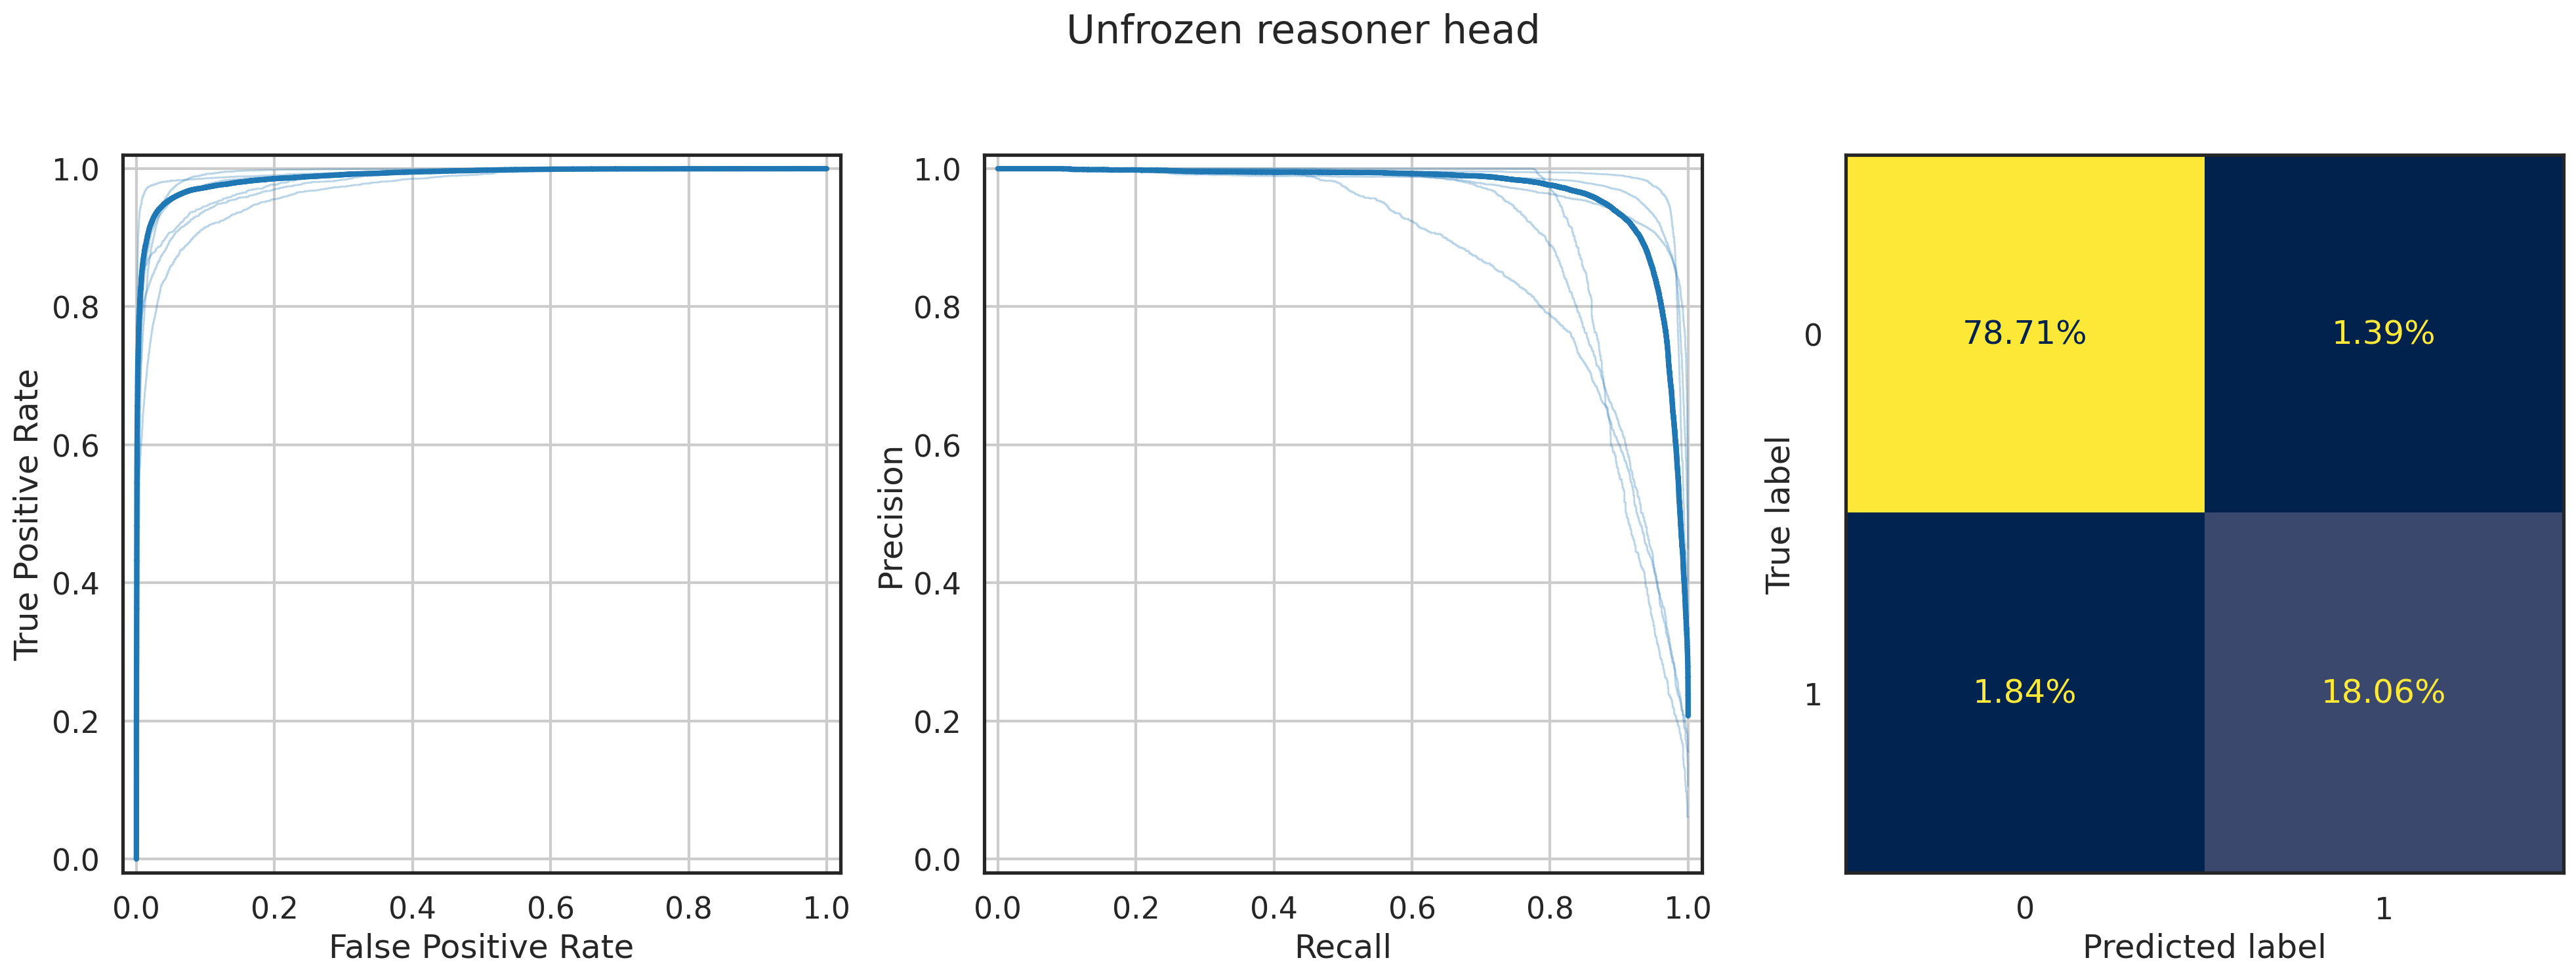

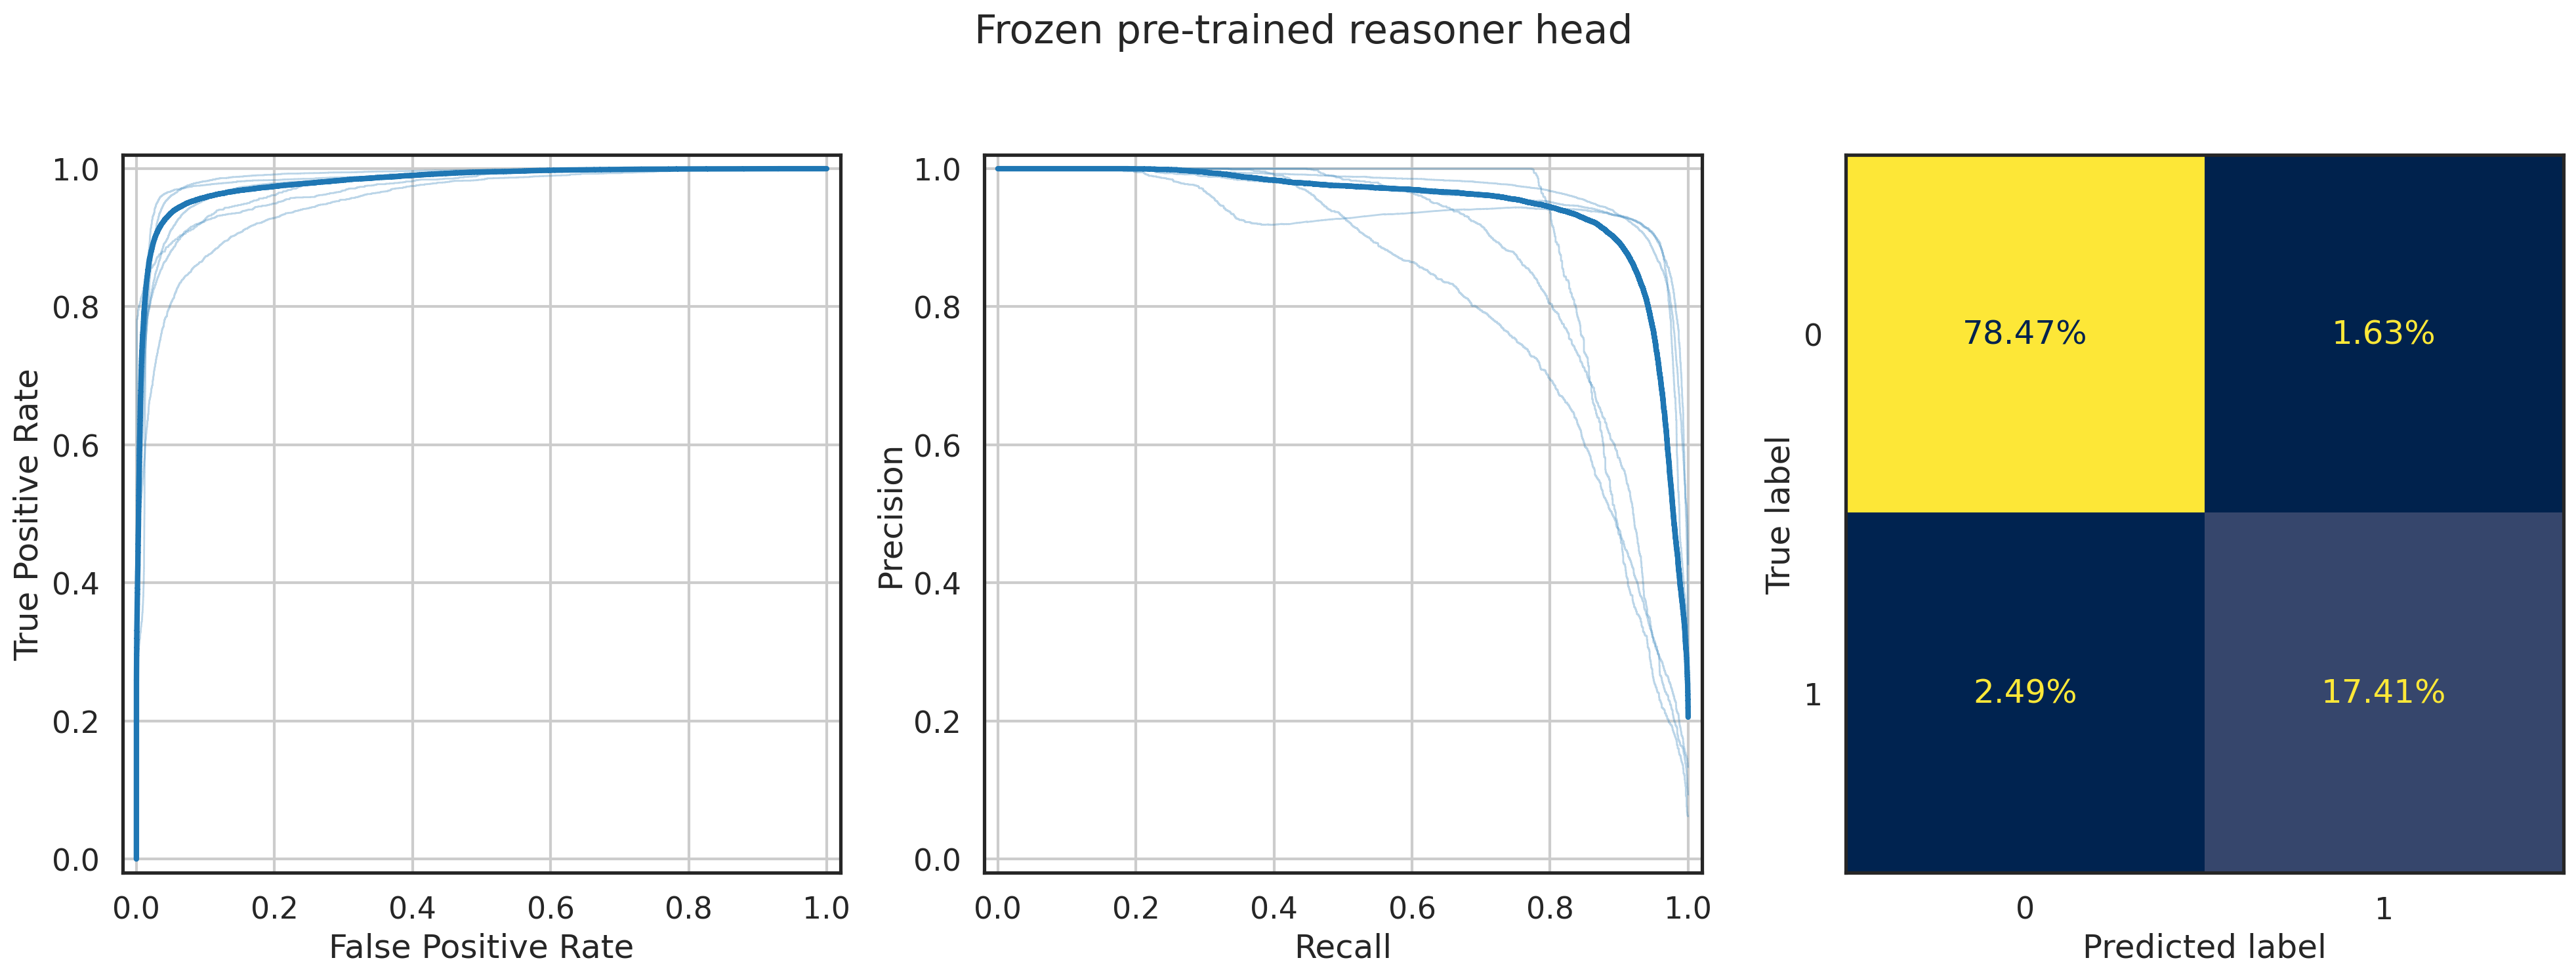

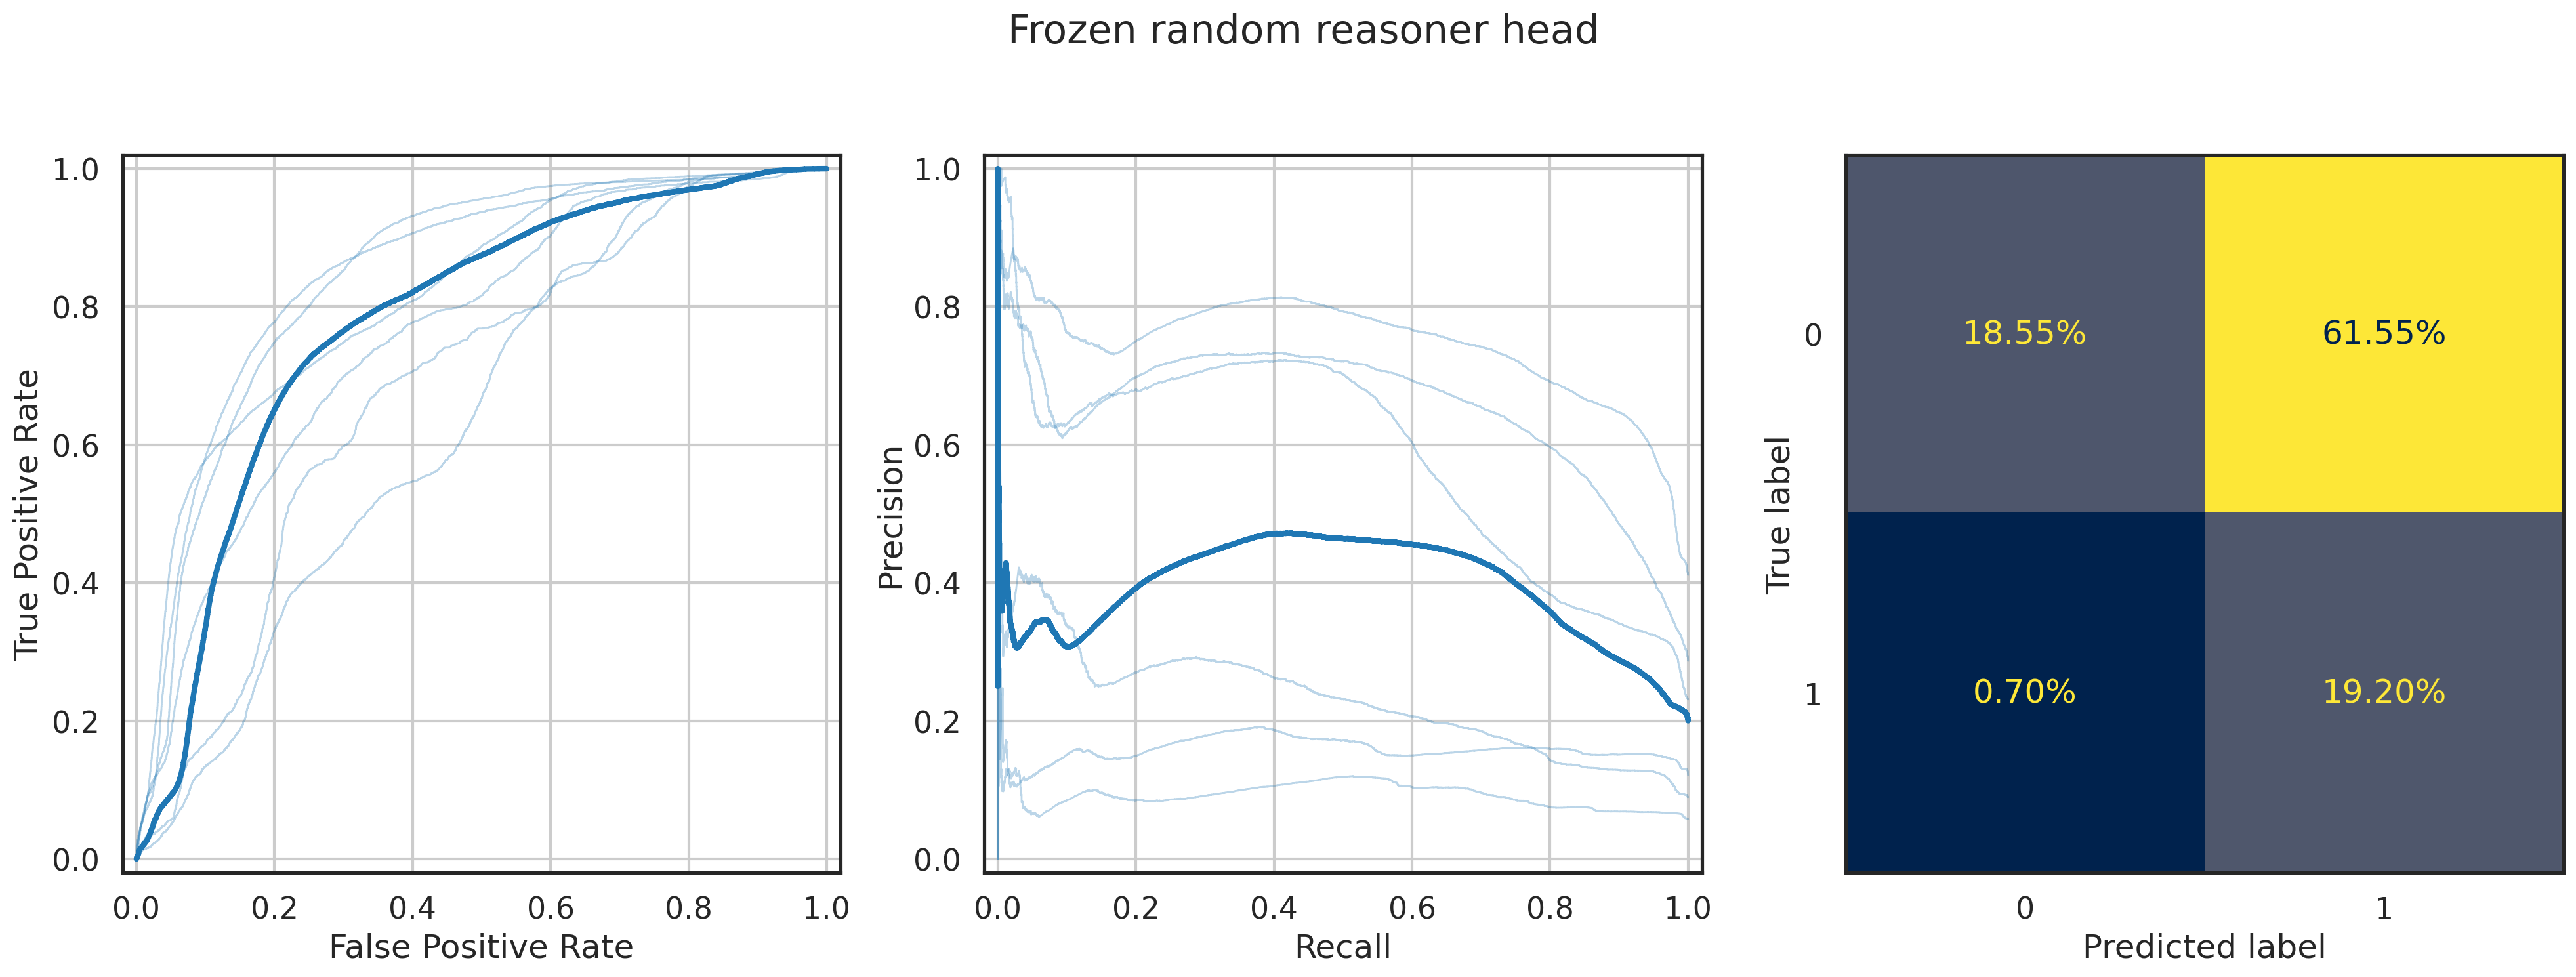

In [6]:
titles = 'Expected', 'Unfrozen reasoner head', 'Frozen pre-trained reasoner head', 'Frozen random reasoner head'
logs = unfrozen_log, transfer_log, random_log
heads = unfrozen_r_head, transfer_r_head, random_r_head
embeddings = unfrozen_r_embs, transfer_r_embs, random_r_embs

base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    print('------')
    with T.no_grad():
        head.eval()
        _, _, Y_te = eval_batch(head, embs, X_te, y_te, idx_te)
    print(title)
    
    history_tr = pd.DataFrame(log.history_tr)
    test_history_by_onto = pd.DataFrame(log.history_vl_by_onto)
    test_history = pd.DataFrame(log.history_vl)
    test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te=Y_te))
    test_history.to_csv(base+f'/{title} test.csv', index=False)
    test_history_by_onto.to_csv(base+f'/{title} test by onto.csv', index=False)
    test_results.to_csv(base+f'/{title} test clas.csv', index=False)

    print('train time', history_tr.groupby('epoch').max().elapsed.sum())
    print(report(ontos, y_te, Y_te, idx_te).round(4))
    plt.suptitle(title)

In [7]:
for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    df = pd.DataFrame(log.history_vl_by_onto)
    df = df[df.epoch == df.epoch.max()].drop(columns=['epoch', 'run', 'elapsed'])
    df.onto = df.onto.map(onto_names.__getitem__)
    print('-'*10)
    print(title)
    #print(df.agg(['mean', 'std']).round(4).T)
    print(df.round(4))

----------
Unfrozen reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9519  0.7911  0.8315  0.7545   0.9683  0.8782  wildlife
61  0.9877  0.8772  0.9785  0.7949   0.9834  0.9149  exchange
62  0.9834  0.9636  0.9719  0.9555   0.9944  0.9867     stuff
63  0.9580  0.9281  0.9118  0.9450   0.9914  0.9783       swo
64  0.9736  0.8403  0.9132  0.7782   0.9797  0.9097    ontodt
65  0.9520  0.9417  0.9401  0.9434   0.9864  0.9801     pizza
----------
Frozen pre-trained reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9423  0.7382  0.8170  0.6732   0.9526  0.8355  wildlife
61  0.9874  0.8734  0.9900  0.7814   0.9784  0.8989  exchange
62  0.9652  0.9245  0.9241  0.9249   0.9822  0.9401     stuff
63  0.9571  0.9256  0.9201  0.9311   0.9860  0.9642       swo
64  0.9675  0.7977  0.8975  0.7179   0.9701  0.8828    ontodt
65  0.9337  0.9189  0.9241  0.9138   0.9781  0.9713     pizza
----------
Frozen random reasoner head
       acc     